In [6]:
import torch 
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from torchsummary import summary
from tqdm import tqdm
import transform

import mydataset

c:\Users\Administrator\anaconda3\envs\box\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = models.vgg16(pretrained=True)

c:\Users\Administrator\anaconda3\envs\box\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\box\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
#
for param in model.parameters():
  param.requires_grad = False

In [10]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

In [11]:
final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(300, 8),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [12]:
model = model.to(device)


In [25]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
summary(model,(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# getting the optimizer and loss_function 
def get_essentials():  
    loss_fun = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [14]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    img = data['image']
    true_points = data ['keypoints']
    true_points = true_points.type(torch.FloatTensor)
    true_points=true_points.flatten()
    print(true_points.shape)
    img = img.type(torch.FloatTensor)
    pred_points = model(img)
    pred_points=pred_points.flatten()
    print(pred_points.shape)
    loss_val = loss_fun(pred_points, true_points)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_val.item()

In [15]:
@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img = data['image']
  true_points = data ['keypoints']
  true_points = true_points.type(torch.FloatTensor)
  true_points=true_points.flatten()
  img = img.type(torch.FloatTensor)

  pred_points = model(img)
  pred_points=pred_points.flatten()
  
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()

In [16]:
epochs = 5
loss_fun, optimizer = get_essentials()

In [17]:
DIR = r'C:\\Users\Administrator\Desktop\AIOR_Group\\Project1\src\box_dataset'
triandataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'train')
testdataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'test')
#print(dataobj[10]['image'].shape)
train_dataloader = DataLoader(triandataobj, batch_size=20, shuffle=True)
test_dataloader = DataLoader(testdataobj, batch_size=20, shuffle=True)

range(0, 200)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
range(200, 250)
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [18]:
import numpy as np

train_epoch, val_epoch = [], []

for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []
  for data in train_dataloader:
    train_batch_loss = train_batch(data, model, loss_fun, optimizer)
    train_batch_losses.append(train_batch_loss)

  for data in test_dataloader:
    val_batch_loss = val_batch(data, model, loss_fun, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([160])


  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[20, 256, 256, 3] to have 3 channels, but got 256 channels instead

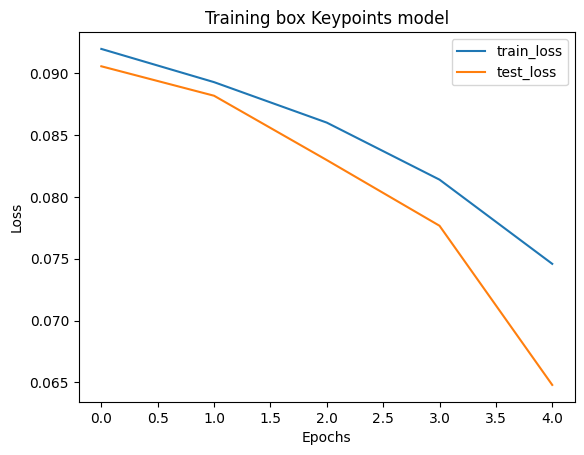

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training box Keypoints model")
plt.show()

In [5]:
index = 8
sample = testdataobj[index]
print(sample['image'].shape)
img = sample['image'].squeeze()
print(img.shape)
plt.imshow(img)
plt.show()
#keypoints = model(sample['image']).flatten().detach().cpu()




NameError: name 'testdataobj' is not defined

In [ ]:

img = sample['image'].squeeze()
print(img)
print(img.shape)




ax[i].imshow(img)
corners = np.array(train_target['keypoints'][i])
corners = np.multiply(corners,256)
print(corners)
P = patches.Polygon(corners, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(P)
ax.set_title(train_target['labels'][i], fontsize=8)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()